This is just going to train a simple model using the converted images.
I'm now following the 7th lesson of fastai which covers this as well.

This time I am going to flatten the input images with an initial layer.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

from src.models.train_model import load_data
from src.models.predict_model import submission
from src.paths import TRAIN_FOLDER, TEST_FOLDER, SUBMISSION_CSV

In [3]:
defaults.cmap='binary'

In [4]:
data = load_data(TRAIN_FOLDER)

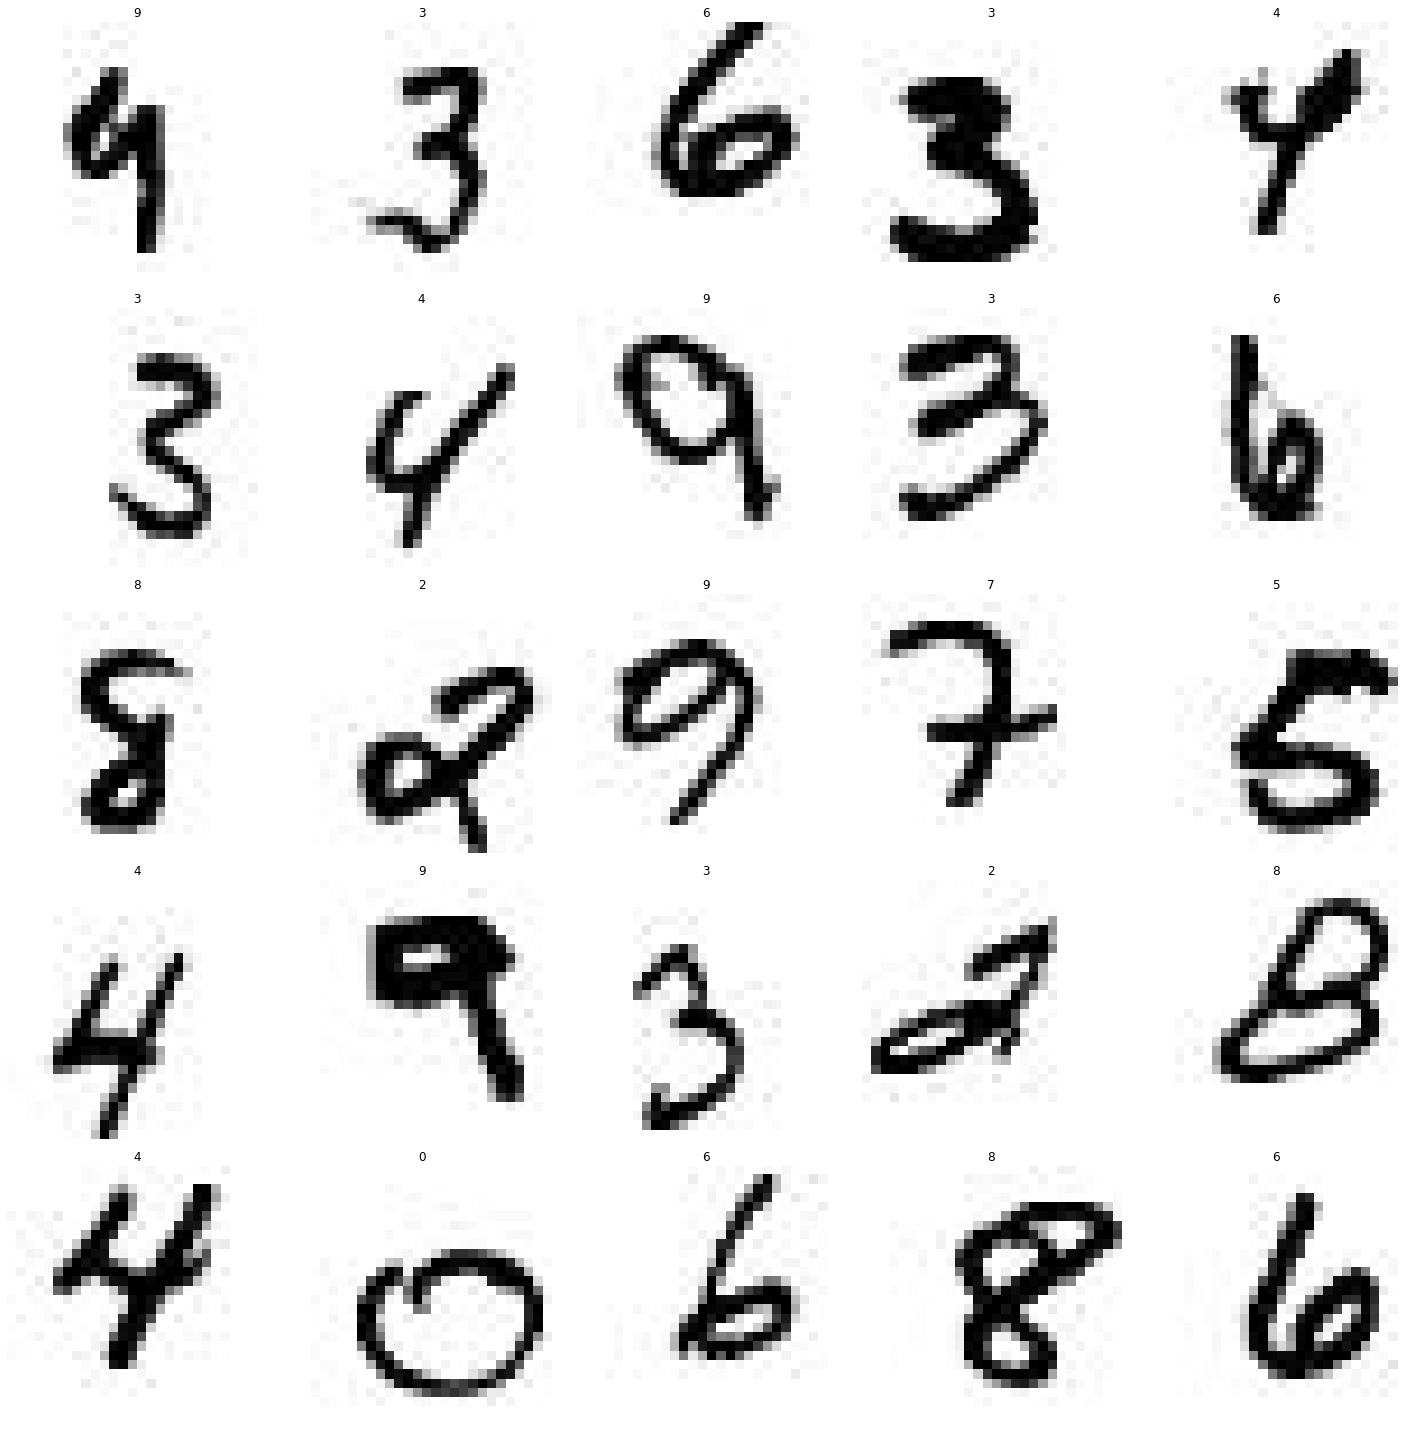

In [5]:
data.show_batch()

### Correct Shape

At this point I have changed the loader enough to load monochrome images, so I no longer need the max layer.
That should make things a little faster.

Jeremy was talking about the 20 -> 56 layer conv net with skip layers so now I want to reproduce that.
This should do a reduction and then 2x 1 stride convolutions with a skip.

In [6]:
data.train_ds[0]

(Image (1, 28, 28), Category 2)

In [7]:
??conv_layer

Signature:
conv_layer(
    ni: int,
    nf: int,
    ks: int = 3,
    stride: int = 1,
    padding: int = None,
    bias: bool = None,
    is_1d: bool = False,
    norm_type: Union[fastai.layers.NormType, NoneType] = <NormType.Batch: 1>,
    use_activ: bool = True,
    leaky: float = None,
    transpose: bool = False,
    init: Callable = <function kaiming_normal_ at 0x7f66dce04bf8>,
    self_attention: bool = False,
)
Source:   
def conv_layer(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias:bool=None, is_1d:bool=False,
               norm_type:Optional[NormType]=NormType.Batch,  use_activ:bool=True, leaky:float=None,
               transpose:bool=False, init:Callable=nn.init.kaiming_normal_, self_attention:bool=False):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and batchnorm (if `bn`) layers."
    if padding is None: padding = (ks-1)//2 if not transpose else 0
    bn = norm_type in (NormType.Batch, NormType.BatchZero)
    if bias is No

In [9]:
??res_block

Signature:
res_block(
    nf,
    dense: bool = False,
    norm_type: Union[fastai.layers.NormType, NoneType] = <NormType.Batch: 1>,
    bottle: bool = False,
    **conv_kwargs,
)
Source:   
def res_block(nf, dense:bool=False, norm_type:Optional[NormType]=NormType.Batch, bottle:bool=False, **conv_kwargs):
    "Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`."
    norm2 = norm_type
    if not dense and (norm_type==NormType.Batch): norm2 = NormType.BatchZero
    nf_inner = nf//2 if bottle else nf
    return SequentialEx(conv_layer(nf, nf_inner, norm_type=norm_type, **conv_kwargs),
                      conv_layer(nf_inner, nf, norm_type=norm2, **conv_kwargs),
                      MergeLayer(dense))
File:      ~/.local/share/virtualenvs/digit-recognizer-1OQ1lSOx/lib/python3.7/site-packages/fastai/layers.py
Type:      function


In [6]:
class Skip(nn.Module):
    """ 2 convolutions followed by adding to the input (skip) """
    def __init__(self, size):
        super().__init__()
        self.conv_1 = conv_layer(size, size, stride=1, use_activ=True, leaky=0.1)
        self.conv_2 = conv_layer(size, size, stride=1, use_activ=True, leaky=0.1)
    
    def forward(self, x):
        out = self.conv_1(x)
        out = self.conv_2(out)
        return x + out

In [7]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [8]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [9]:
model = nn.Sequential(
    conv2(1, 8),
    Skip(8),
    conv2(8, 16),
    Skip(16),
    conv2(16, 32),
    Skip(32),
    conv2(32, 16),
    Skip(16),
    conv2(16, 10),
    Flatten()
)

In [10]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [21]:
learn.fit_one_cycle(10, max_lr=0.1)

In [22]:
learn.save('06-skip-model-1')

In the paper that Jeremy references there is only a relu between the convolutions in the skip.
So I could make this faster by removing the second relu.

In [11]:
class Skip(nn.Module):
    """ 2 convolutions followed by adding to the input (skip) """
    def __init__(self, size):
        super().__init__()
        self.conv_1 = conv_layer(size, size, stride=1, use_activ=True, leaky=0.1)
        self.conv_2 = conv_layer(size, size, stride=1)
    
    def forward(self, x):
        out = self.conv_1(x)
        out = self.conv_2(out)
        return x + out

In [12]:
model = nn.Sequential(
    conv2(1, 8),
    Skip(8),
    conv2(8, 16),
    Skip(16),
    conv2(16, 32),
    Skip(32),
    conv2(32, 16),
    Skip(16),
    conv2(16, 10),
    Flatten()
)

In [13]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [27]:
learn.fit_one_cycle(10, max_lr=0.1)

In [28]:
learn.save('06-skip-model-2')

In [29]:
learn.fit_one_cycle(25, max_lr=0.1)

In [30]:
learn.save('06-skip-model-3')

### Submission

This isn't better (because the last skip one also had the same structure) however I will submit it to see how it does.

In [14]:
learn.load('06-skip-model-3')
df = submission(learn, TEST_FOLDER, convert_mode='L')

/home/matthew/.local/share/virtualenvs/digit-recognizer-1OQ1lSOx/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Skip. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
100%|██████████| 28000/28000 [02:54<00:00, 160.72it/s]


In [15]:
df.head()

Label
ImageId      
1           2
2           0
3           9
4           0
5           3

In [16]:
df.to_csv(SUBMISSION_CSV)

was: `1686 Matthew Franglen 0.98271`<br/>
was: `0731 Matthew Franglen 0.99428`<br/>
was: `0694 Matthew Franglen 0.99457`<br/>
now: `xxxx Matthew Franglen 0.99300`

So the skip architecture is not an improvement. This is because the previous version was already a skip architecture!
The res_block used is a skip.

The next thing to try would be a dense architecture however it's late now.